In [1]:
import os

os.environ["CUDA_DEVICE_ORDER"]="PCI_BUS_ID"
os.environ["CUDA_VISIBLE_DEVICES"]="1"

import tensorflow as tf

config = tf.compat.v1.ConfigProto()
config.gpu_options.allow_growth=True

sess = tf.compat.v1.Session(config=config)

import numpy as np
import pandas as pd
import pickle
import matplotlib.pyplot as plt
from PIL import Image
from IPython.display import Audio
from matplotlib.pyplot import imshow
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import OneHotEncoder
from sklearn.utils.class_weight import compute_class_weight

from tensorflow.keras import layers
from tensorflow.keras import models
from tensorflow.keras import layers
from tensorflow.keras import optimizers
from tensorflow.keras import callbacks
from tensorflow.keras import regularizers
from tensorflow.keras import models

%matplotlib inline

In [3]:
IMG_DIR = 'F:\MLP\music-genre-classification-master\music-genre-classification-master\spectrogram_images\spectrogram_images'
IMG_HEIGHT = 216
IMG_WIDTH = 216
NUM_CLASSES = 7
NUM_EPOCHS = 6
BATCH_SIZE = 32
L2_LAMBDA = 0.001

In [4]:
# Randomly select 1 spectrogram from each category for plotting
sample_files = ['136_Hip_hop_music.jpg', 
                 '6627_Pop_music.jpg',
                 '38706_Vocal.jpg',
                 '3400_Rhythm_blues.jpg',
                 '12908_Reggae.jpg',
                 '22013_Rock_music.jpg',
                 '21173_Techno.jpg']
label_dict = {'Hip':0,
              'Pop':1,
              'Vocal':2,
              'Rhythm':3,
              'Reggae':4,
              'Rock':5,
              'Techno':6,
             }
one_hot = OneHotEncoder()
all_files = os.listdir(IMG_DIR)
label_array =[]

for file_ in all_files[0:20000]:
    vals = file_[:-4].split('_')
    label_array.append(label_dict[vals[1]])

# Get class weights
cl_weight = compute_class_weight(class_weight = 'balanced', 
                                classes = np.unique(label_array), 
                                y = label_array)
cl_weight = {i : cl_weight[i] for i in range(NUM_CLASSES)}
# Train-val-test split of files
#label_array= np.array(label_array).reshape(len(label_array),1)
#label_array = one_hot.fit_transform(label_array).toarray()
train_files, test_files, train_labels, test_labels = train_test_split(all_files[0:20000], 
                                                                      label_array,
                                                                      random_state = 10, 
                                                                      test_size = 0.1
                                                                     )
print(np.shape(train_files))
print(np.shape(test_files))
print(np.shape(train_labels))
print(np.shape(test_labels))
# Among the test files, keep half for validation
val_files, test_files, val_labels, test_labels = train_test_split(test_files, test_labels,
                                                                  random_state = 10, 
                                                                  test_size = 0.5
                                                                 )

(18000,)
(2000,)
(18000,)
(2000,)


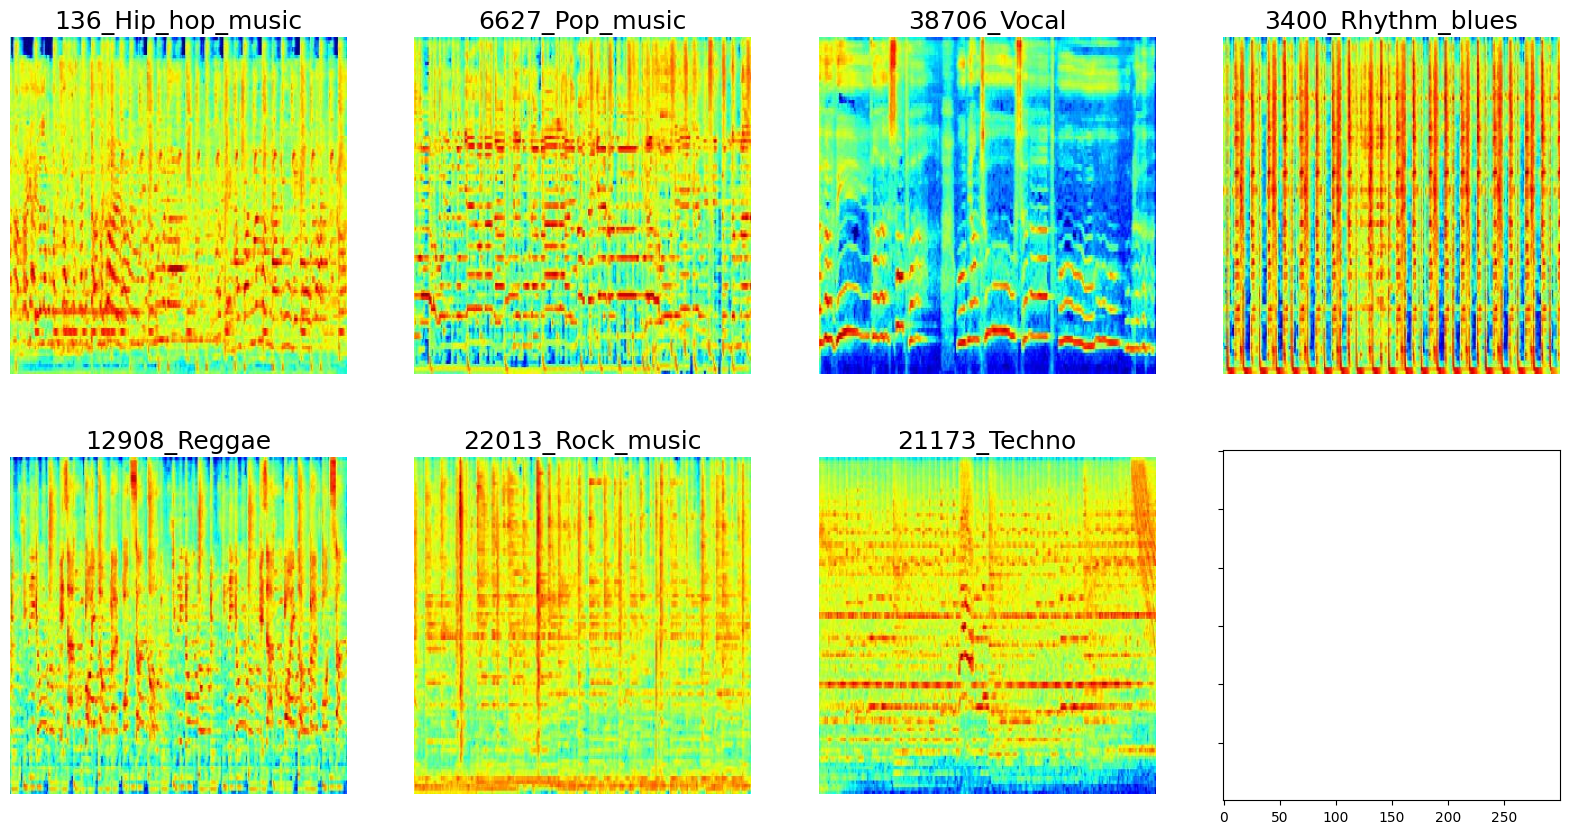

In [5]:
f, axarr = plt.subplots(2, 4, sharex=True, sharey=True, figsize=(20,10))
coordinates = [(0,0),(0,1),(0,2),(0,3), 
               (1,0),(1,1),(1,2) ]

for i, file_ in enumerate(sample_files):
    im = Image.open(os.path.join(IMG_DIR,file_))
    # im = im.resize((IMG_WIDTH, IMG_HEIGHT), resample = Image.ANTIALIAS)
    axarr[coordinates[i]].imshow(np.asarray(im))
    axarr[coordinates[i]].axis('off')
    axarr[coordinates[i]].set_title(file_[:-4], fontsize=18)


Samples above show that the spectrograms are different for different genres.

In [6]:
conv_base = tf.keras.applications.VGG16(include_top = False, 
                                            weights = 'imagenet', 
                                            input_shape = (IMG_WIDTH, IMG_HEIGHT, 3) # 3 channels - RGB
                                           ) 
# The weights are for the CONV filters - hence you can pass any pre-set image size to this VGG network
# Need not be 224 x 224 x 3 (Although does it work better for 224 size? Need to check)

In [7]:
conv_base.summary()

Model: "vgg16"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 input_1 (InputLayer)        [(None, 216, 216, 3)]     0         
                                                                 
 block1_conv1 (Conv2D)       (None, 216, 216, 64)      1792      
                                                                 
 block1_conv2 (Conv2D)       (None, 216, 216, 64)      36928     
                                                                 
 block1_pool (MaxPooling2D)  (None, 108, 108, 64)      0         
                                                                 
 block2_conv1 (Conv2D)       (None, 108, 108, 128)     73856     
                                                                 
 block2_conv2 (Conv2D)       (None, 108, 108, 128)     147584    
                                                                 
 block2_pool (MaxPooling2D)  (None, 54, 54, 128)       0     

In [8]:
model = models.Sequential()
model.add(conv_base)
model.add(layers.Flatten()) # Flatten output and send it to MLP

# 1-layer MLP with Dropout, BN 
model.add(layers.Dense(512, name='dense_1', kernel_regularizer=regularizers.l2(L2_LAMBDA)))
model.add(layers.Dropout(rate=0.3, name='dropout_1')) # Can try varying dropout rates
model.add(layers.Activation(activation='relu', name='activation_1'))

model.add(layers.Dense(NUM_CLASSES, activation='softmax', name='dense_output'))
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 24,155,975
Trainable params: 24,155,975
No

In [9]:
# Set the convolution base to be not trainable
conv_base.trainable = False
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 vgg16 (Functional)          (None, 6, 6, 512)         14714688  
                                                                 
 flatten (Flatten)           (None, 18432)             0         
                                                                 
 dense_1 (Dense)             (None, 512)               9437696   
                                                                 
 dropout_1 (Dropout)         (None, 512)               0         
                                                                 
 activation_1 (Activation)   (None, 512)               0         
                                                                 
 dense_output (Dense)        (None, 7)                 3591      
                                                                 
Total params: 24,155,975
Trainable params: 9,441,287
Non

In [10]:
def load_batch(file_list):
    img_array = []
    idx_array = []
    label_array = []

    for file_ in file_list:
        im = Image.open(os.path.join(IMG_DIR,file_))
        im = im.resize((IMG_WIDTH, IMG_HEIGHT), Image.Resampling.LANCZOS)
        img_array.append(np.array(im))

        vals = file_[:-4].split('_')
        idx_array.append(vals[0])
        label_array.append([label_dict[vals[1]]])
    #label_array= np.array(label_array).reshape(len(label_array),1)
    #label_array = one_hot.fit_transform(label_array).toarray()
    img_array = np.array(img_array)/255.0 # Normalize RGB
    
    return img_array, np.array(label_array), np.array(idx_array)

In [11]:
def batch_generator(files, BATCH_SIZE):
    L = len(files)

    #this line is just to make the generator infinite, keras needs that    
    while True:

        batch_start = 0
        batch_end = BATCH_SIZE

        while batch_start < L:
            
            limit = min(batch_end, L)
            file_list = files[batch_start: limit]
            batch_img_array, batch_label_array, batch_idx_array = load_batch(file_list)

            yield (batch_img_array, batch_label_array) # a tuple with two numpy arrays with batch_size samples     

            batch_start += BATCH_SIZE   
            batch_end += BATCH_SIZE

In [12]:
# Set optimizer, loss and metrics
optimizer = optimizers.Adam(learning_rate=1e-5)

loss = 'sparse_categorical_crossentropy'

metrics = ['sparse_categorical_accuracy']

filepath=os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\saved_models','transfer_learning_epoch_{epoch:02d}_{val_sparse_categorical_accuracy:.4f}.h5')
checkpoint = callbacks.ModelCheckpoint(filepath, 
                                       monitor='val_sparse__categorical_accuracy', 
                                       verbose=0, 
                                       save_best_only=False)
callbacks_list = [checkpoint]

model.compile(optimizer=optimizer, loss=loss, metrics=metrics)

In [13]:
STEPS_PER_EPOCH = len(train_files)//BATCH_SIZE
VAL_STEPS = len(val_files)//BATCH_SIZE
history = model.fit(batch_generator(train_files, BATCH_SIZE),
                              epochs     = NUM_EPOCHS,
                              steps_per_epoch = STEPS_PER_EPOCH,
                              validation_data = batch_generator(val_files, BATCH_SIZE), 
                              validation_steps = VAL_STEPS, 
                              callbacks = callbacks_list,
                              class_weight = cl_weight,
                             )

Epoch 1/6
562/562 [==============================] - 3440s 6s/step - loss: 2.5235 - sparse_categorical_accuracy: 0.3498 - val_loss: 2.2246 - val_sparse_categorical_accuracy: 0.4536
Epoch 2/6
562/562 [==============================] - 3859s 7s/step - loss: 2.1385 - sparse_categorical_accuracy: 0.4585 - val_loss: 2.0300 - val_sparse_categorical_accuracy: 0.4879
Epoch 3/6
562/562 [==============================] - 3324s 6s/step - loss: 1.9821 - sparse_categorical_accuracy: 0.4859 - val_loss: 1.9282 - val_sparse_categorical_accuracy: 0.4980
Epoch 4/6
562/562 [==============================] - 3550s 6s/step - loss: 1.8820 - sparse_categorical_accuracy: 0.5059 - val_loss: 1.8692 - val_sparse_categorical_accuracy: 0.4990
Epoch 5/6
562/562 [==============================] - 3396s 6s/step - loss: 1.8108 - sparse_categorical_accuracy: 0.5233 - val_loss: 1.8214 - val_sparse_categorical_accuracy: 0.5181
Epoch 6/6
562/562 [==============================] - 3429s 6s/step - loss: 1.7561 - sparse_cate

In [14]:
# Save scores on train and validation sets
with open(os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\pickle_files','transfer_learning_vgg16_history.pkl'), 'wb') as f:
    pickle.dump(history.history, f)

#### Determine the best performing model

In [16]:
# Load scores
with open(os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\pickle_files','transfer_learning_vgg16_history.pkl'), 'rb') as f:
    scores = pickle.load(f)
print(scores.keys())
scores = pd.DataFrame(scores, index=range(1,7))

dict_keys(['loss', 'sparse_categorical_accuracy', 'val_loss', 'val_sparse_categorical_accuracy'])


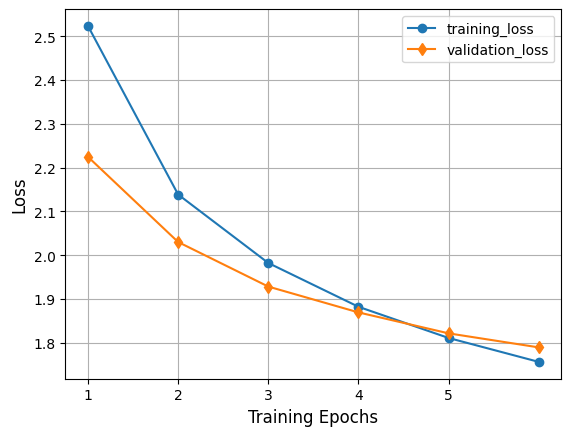

In [17]:
plt.xticks(range(1,6))
plt.plot(scores['loss'], marker='o', label='training_loss')
plt.plot(scores['val_loss'], marker='d', label='validation_loss')
plt.ylabel('Loss', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

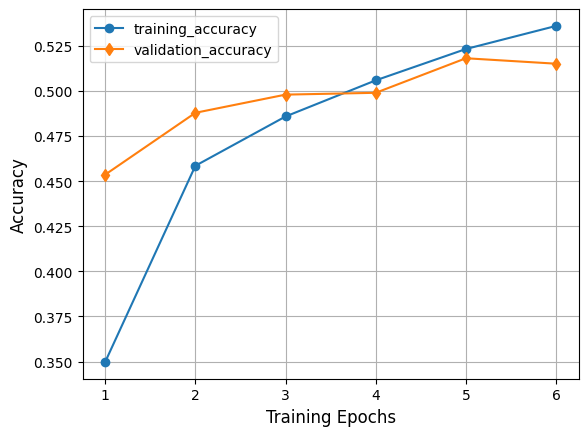

In [18]:
plt.xticks(range(1,7))
plt.plot(scores['sparse_categorical_accuracy'], marker='o', label='training_accuracy')
plt.plot(scores['val_sparse_categorical_accuracy'], marker='d', label='validation_accuracy')
plt.ylabel('Accuracy', fontsize=12)
plt.xlabel('Training Epochs', fontsize=12)
plt.grid()
plt.legend()

Choose epoch 5 to be the model that does well on the validation set (in terms of minimum loss and maximum accuracy).

In [19]:
model = models.load_model(filepath=os.path.join('F:\MLP\music-genre-classification-master\music-genre-classification-master\saved_models','transfer_learning_epoch_05_0.5181.h5')) # 02 is epoch 5

In [20]:
# Make Prediction on Test set
TEST_STEPS = len(test_files)//BATCH_SIZE
pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE), 
                                     steps=TEST_STEPS)
pred = np.argmax(pred_probs, axis=-1)

C:\Users\Vishnuvardhan\AppData\Local\Temp\ipykernel_18480\363454299.py:3: UserWarning: `Model.predict_generator` is deprecated and will be removed in a future version. Please use `Model.predict`, which supports generators.
  pred_probs = model.predict_generator(generator = batch_generator(test_files, BATCH_SIZE),


### Evaluation of the best performing model

In [21]:
from sklearn.metrics import confusion_matrix, f1_score, accuracy_score, roc_auc_score, roc_curve, auc
from scipy import interp
import itertools
from itertools import cycle
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion matrix, without normalization')

    print(cm)

    thresh = cm.max() / 2.
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, cm[i, j],
                 horizontalalignment="center",
                 color="white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')
    
def one_hot_encoder(true_labels, num_records, num_classes):
    temp = np.array(true_labels[:num_records])
    true_labels = np.zeros((num_records, num_classes))
    true_labels[np.arange(num_records), temp] = 1
    return true_labels

Confusion matrix, without normalization
[[ 82   4   4   6  40   4   9]
 [ 16  33  16  11  28  35  15]
 [  4   6  49   0   1   4   3]
 [ 11   8  11  24  25  11  15]
 [  8   4   2   7  37   5   1]
 [  5  14  17  10  14 135  18]
 [ 17  17  11  10   6  20 159]]


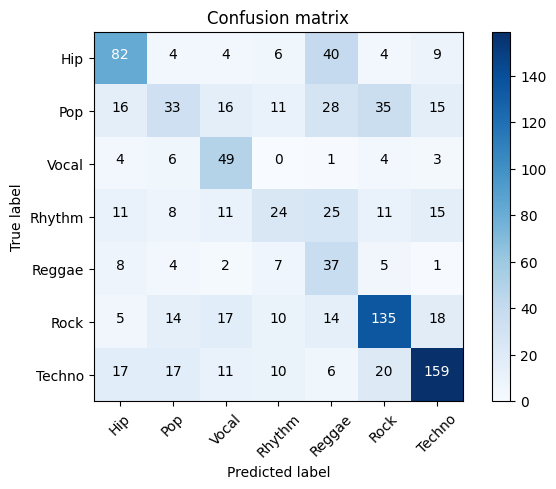

In [22]:
plot_confusion_matrix(confusion_matrix(y_true=test_labels[:len(pred)], y_pred=pred), 
                      classes=label_dict.keys())

In [23]:
print('Test Set Accuracy =  {0:.2f}'.format(accuracy_score(y_true=test_labels[:len(pred)], y_pred=pred)))
print('Test Set F-score =  {0:.2f}'.format(f1_score(y_true=test_labels[:len(pred)], y_pred=pred, average='macro')))

Test Set Accuracy =  0.52
Test Set F-score =  0.48


In [24]:
one_hot_true = one_hot_encoder(test_labels, len(pred), len(label_dict))
print('ROC AUC = {0:.3f}'.format(roc_auc_score(y_true=one_hot_true, y_score=pred_probs, average='macro')))

ROC AUC = 0.832


C:\Users\Vishnuvardhan\AppData\Local\Temp\ipykernel_18480\1651430764.py:16: DeprecationWarning: scipy.interp is deprecated and will be removed in SciPy 2.0.0, use numpy.interp instead
  mean_tpr += interp(all_fpr, fpr[i], tpr[i])


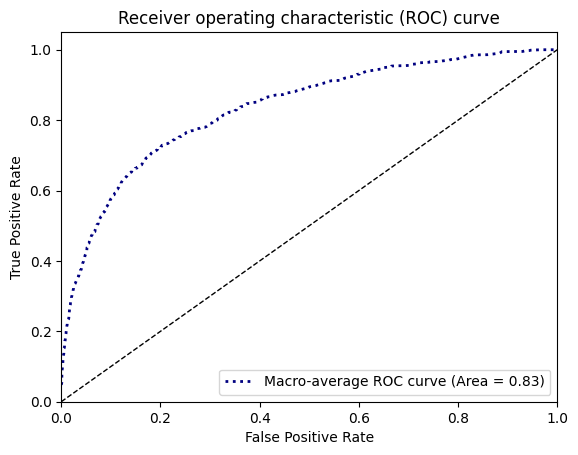

In [25]:
# Compute macro-average ROC curve and ROC area
# Compute ROC curve and ROC area for each class
fpr = dict()
tpr = dict()
roc_auc = dict()
for i in range(NUM_CLASSES):
    fpr[i], tpr[i], _ = roc_curve(one_hot_true[:, i], pred_probs[:, i])
    roc_auc[i] = auc(fpr[i], tpr[i])    

# First aggregate all false positive rates
all_fpr = np.unique(np.concatenate([fpr[i] for i in range(NUM_CLASSES)]))

# Then interpolate all ROC curves at this points
mean_tpr = np.zeros_like(all_fpr)
for i in range(NUM_CLASSES):
    mean_tpr += interp(all_fpr, fpr[i], tpr[i])

# Finally average it and compute AUC
mean_tpr /= NUM_CLASSES

fpr["macro"] = all_fpr
tpr["macro"] = mean_tpr
roc_auc["macro"] = auc(fpr["macro"], tpr["macro"])

# Plot all ROC curves
plt.figure()
plt.plot(fpr["macro"], tpr["macro"],
         label='Macro-average ROC curve (Area = {0:0.2f})'
               ''.format(roc_auc["macro"]),
         color='navy', linestyle=':', linewidth=2)

plt.plot([0, 1], [0, 1], 'k--', lw=1)
plt.xlim([0.0, 1.0])
plt.ylim([0.0, 1.05])
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic (ROC) curve')
plt.legend(loc="lower right")
plt.show()